In [ ]:
# Import Library
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
import warnings
warnings.filterwarnings("ignore")


In [3]:
movie = pd.read_csv('movie_preprocessing5.csv',encoding='utf-8')
# movie=movie1[:5000]

## Weight Rating


### 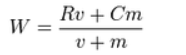

- W: weight rating
- R: average score for the movie
- v: number of review_count for the movie
- m: minimum review_count required to be listed
- C: the mean score across the whole dataset

In [4]:
C = movie['Score'].mean()
m =  movie['Review count'].quantile(0.9)
# movie_list = movie.copy().loc[movie['Review count']>=m]

In [5]:
# Defining a function
def weighted_rating(x,m=m,C=C):
    v=x['Review count']
    R=x['Score']
    return ((R*v+C*m)/(v+m))

In [6]:
# movie_list['WR_score']=movie_list.apply(weighted_rating,axis=1)
# movie_list.head()

# Sort the movies based on their WR_score
# movie_list = movie_list.sort_values('WR_score',ascending=False)
# movie_list.head(10)

## Cosine Similarity

In [7]:
movie['General'] = movie['Genre'] + ' '  + movie['Original Language']+ ' ' + movie['Rating']+' '+ movie['Director'] + ' ' + movie['Cast']+' ' + movie['Synopsis']

In [7]:
for i in movie['General'][:10]:
  print(i)

Drama Hindi PG-13 R. Balki Amitabh Bachchan, Abhishek Bachchan, Vidya Balan, Paresh Rawal, R. Balki, R. Balki, Sunil Manchanda A politician's 13-year-old son has a rare disorder that makes him appear to be a grown man.
Drama, Comedy English PG-13 Niels Mueller David Sullivan, Bill Heck, Kristen Johnston, Tanya Fischer, Cooper J. Friedman, Braden Andersen, Andi Matusiak, Mark Borchardt, Kendall Dakof, Leah Joy Gayle, Braden Anderson, Niels Mueller, Jason Naczek, Scott K. Foley, Hongtao Liu, Niels Mueller, Josh Rosenberg, Alexander Payne, Jinhua Yang, Nathaniel Goodman, Tracy Adams, Nicholas Jacobson-Larson, Kelly Fallon, Ania Bista, Kate M. Blomquist, Nicole Abellera After losing a custody battle, perpetual teenager Wayne Stobierski steals his son away for one last father-son weekend to the city of their dreams -- Milwaukee, Wisconsin. What's supposed to be a light-hearted adventure, transforms into a journey of profound redemption.
Comedy, Adventure Swedish R Felix Herngren Robert Gust

### Preprocessing

In [8]:
# # Preprocessing Review column
# import pandas as pd
# from nltk.corpus import stopwords
# # from textblob import TextBlob
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# import spacy
# nlp = spacy.load("en_core_web_sm")
# stop_words = set(stopwords.words('english'))
# import re

# def clean_review(text):
#     text = text.lower()
#     text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = text.strip()
#     text = text.replace('\n', ' ')
#     text = re.sub(r'[^\w\s]', '', text)
#     #tokenizing
    
#     # lemmatization
#     doc = nlp(text)
#     text = " ".join([token.lemma_ for token in doc])
#     return text

In [9]:
tfidf= TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie['General'])
tfidf_matrix.shape

(32462, 143425)

In [ ]:
# # Import CountVectorizer and create the count matrix
# from sklearn.feature_extraction.text import CountVectorizer

# count = CountVectorizer(stop_words='english')
# count_matrix = count.fit_transform(movie['General'])
# count_matrix.shape

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Reduce the dimensions of the TF-IDF matrix using SVD
svd = TruncatedSVD(n_components=100)
svd_matrix = svd.fit_transform(tfidf_matrix)
# Calculate cosine similarity on the reduced matrix
cosine_sim = cosine_similarity(svd_matrix, svd_matrix)


In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.metrics.pairwise import cosine_similarity

# # Reduce the dimensions of the TF-IDF matrix using PCA
# pca = PCA(n_components=100)
# pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

# # Calculate cosine similarity on the reduced matrix
# cosine_sim = cosine_similarity(pca_matrix, pca_matrix)


## Recommend Movies

In [11]:
movie = movie.reset_index()
indices = pd.Series(movie.index, index=movie['Title'])

In [13]:
def get_recommendations(title, consine_sim=cosine_sim):
    #index of the movie that matches the title
    idx = indices[title]

    #pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    #Sorting the movies based on the similarity scores
    sim_scores = sorted(sim_scores,key = lambda x: x[1],reverse=True)

    #Scores of 10 most similar movies
    sim_scores = sim_scores[:30]

    #Get the movie index
    movie_indicates = [i[0] for i in sim_scores]

    #Combine Cosine similarity and weight score
    movie_pred = movie.iloc[movie_indicates][['Title', 'Genre','Score','Review count','Original Language']]
    C = movie['Review count'].mean()
    m = movie['Review count'].quantile(0.40)
    t = movie['Score'].quantile(0.5)
    qualified = movie_pred[(movie_pred['Review count'] >= m) & (movie_pred['Score'] >= t)]
    qualified['WR_score'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('WR_score', ascending=False).head(15)
    return qualified

In [15]:
get_recommendations('Your Name')

,Title,Genre,Score,Review count,Original Language,WR_score
25279,Your Name,"Romance, Fantasy, Anime",96.0,10116,Japanese,73.475843
6594,Vampire Hunter D,"Horror, Animation",78.0,25009,Japanese,71.192153
25737,The Girl Who Leapt Through Time,"Drama, Comedy, Sci-fi, Anime",87.0,10019,Japanese,70.855076
14986,Ping Pong,"Drama, Comedy",80.5,2520,Japanese,65.900287
4083,Belle,"Adventure, Romance, Fantasy, Musical, Anime, M...",95.0,627,Japanese,65.182794
28584,Warm Water Under a Red Bridge,"Drama, Romance, Fantasy",78.0,1045,Japanese,64.980959
9054,Ocean Waves,"Drama, Adventure, Anime",76.5,1018,Japanese,64.909367
19357,Weathering With You,"Drama, Fantasy, Anime",94.0,346,Japanese,64.841548
1778,"Josee, The Tiger and the Fish","Drama, Romance, Animation, Anime",98.5,265,Japanese,64.795667


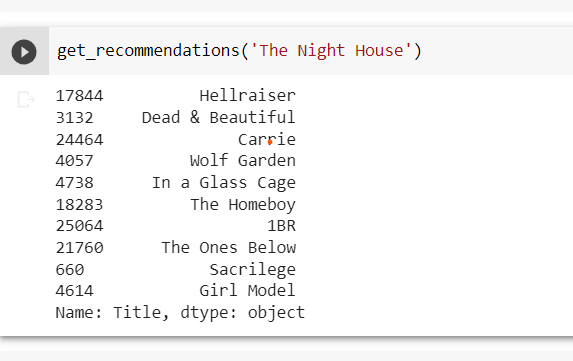